In [3]:
import numpy as np
import os
from scipy import linalg
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import patches
%matplotlib inline

In [4]:
mat_path = "../output/BOSS_DR12_NGC_z1/matrices/"

In [34]:
#estimates = [
#    ["cov", "sample", "Sample"],
#    ["cov", "shrinkage_Sii", "Covariance shrinkage with\n target $\mathbf{T}^{(1)}$ (empirical)"],
#    ["cov", "shrinkage_P", "Covariance shrinkage with\n target $\mathbf{T}^{(2)}$ (analytical)"],
#    ["cov", "NERCOME", "NERCOME"],
#]
estimates = [
    ["pre", "shrinkage_inv_then_diag", "Precision shrinkage with\n target $\mathbf{\Pi}_0^{(1)}$ (empirical)"],
    ["pre", "shrinkage_diag_then_inv", "Precision shrinkage with\n target $\mathbf{\Pi}_0^{(2)}$ (empirical)"],
    ["pre", "shrinkage_P", "Precision shrinkage with\n target $\mathbf{\Pi}_0^{(3)}$ (analytical)"],
]
n = 21

In [35]:
C_ref = np.loadtxt(os.path.join(mat_path, "n2048/cov_sample/cov_18_18_sample_2048_v1.matrix"))
Cinv_ref = np.linalg.inv(C_ref) * (2048-18-2)/(2048-1)

emodes = np.linspace(1, 18, 18)
evals_ref = np.linalg.eigvalsh(Cinv_ref)

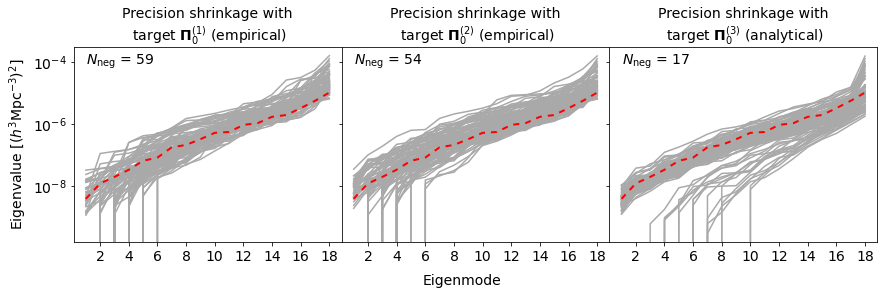

In [37]:
nplots = len(estimates)
fig, axs = plt.subplots(1, nplots, sharey=True)
fig.subplots_adjust(wspace=0)
fig.set_size_inches(4.8*nplots, 3.6)

for k, estimate in enumerate(estimates):
    mat_type = estimate[0]
    est_type = estimate[1]
    plt_title = estimate[2]

    axs[k].plot(emodes, evals_ref, c="red", ls="-", dashes=(3,3), linewidth=2, zorder=10, label="Reference")

    data_path = os.path.join(mat_path, f"n{n}/{mat_type}_{est_type}/")
    filenames = [f for f in os.listdir(data_path) if not f.startswith('.')]

    nr_neg_evals = 0
    for filename in filenames:
        matrix = np.loadtxt(os.path.join(data_path, filename))

        if mat_type == "cov":
            # Obtain precision matrix
            Cinv = np.linalg.inv(matrix)
            if est_type == "sample":
                # Apply Hartlap correction
                H = (n-18-2) / (n-1)
                Cinv = H*Cinv

        elif mat_type == "pre":
            # The matrix is already the precision matrix
            Cinv = matrix

        evals = np.linalg.eigvalsh(Cinv)
        min_eval = np.min(evals)
        if min_eval < 0:
            nr_neg_evals += 1

        curve = axs[k].plot(emodes, evals, c='darkgrey', zorder=1)

    curve[0].set_label("Estimates")

    xticks = np.linspace(2, 18, 9)
    axs[k].set_title(plt_title, fontsize=14)
    axs[k].set_yscale("log")
    #axs[k].legend(loc="upper left", fontsize=14)
    axs[k].set_xticks(xticks)
    axs[k].tick_params(axis='both', which='major', labelsize=14)

    axs[k].text(1,8*1e-5, r"$N_{\rm neg}$ = " + str(nr_neg_evals), fontsize=14)

#axs[0].legend(loc="upper left", fontsize=14)
axs[0].set_ylabel(r"Eigenvalue $[(h^3 \rm{Mpc}^{-3})^2]$", fontsize=14)
fig.supxlabel("Eigenmode", fontsize=14, y=-0.05)

#fig.savefig(f"../output/BOSS_DR12_NGC_z1/plots/eigenspectra_bottom_n{n}.eps", format="eps", bbox_inches='tight', pad_inches = 0.1)
plt.show()

In [42]:
estimates = [
    ["cov", "NERCOME", "NERCOME", "dotted", "indianred"],
    ["cov", "shrinkage_Sii", "Covariance shrinkage with $\mathbf{T}^{(1)}$", (0, (5, 5)), "red"],
    ["cov", "shrinkage_P", "Covariance shrinkage with $\mathbf{T}^{(2)}$", (0, (3, 5, 1, 5)), "darkred"],
    ["pre", "shrinkage_inv_then_diag", "Precision shrinkage with $\mathbf{\Pi}_0^{(1)}$", "dashdot", "lightsteelblue"],
    ["pre", "shrinkage_diag_then_inv", "Precision shrinkage with $\mathbf{\Pi}_0^{(2)}$", "dashed", "blue"],
    ["pre", "shrinkage_P", "Precision shrinkage with $\mathbf{\Pi}_0^{(3)}$", (0, (3, 5, 1, 5, 1, 5)), "navy"],
]

print(f"Computed from {n} mocks:")
for k, estimate in enumerate(estimates):
    mat_type = estimate[0]
    est_type = estimate[1]
    plt_title = estimate[2]
    
    data_path = os.path.join(mat_path, f"n{n}/{mat_type}_{est_type}/")
    filenames = [f for f in os.listdir(data_path) if not f.startswith('.')]
    
    ds = []
    for filename in filenames:
        matrix = np.loadtxt(os.path.join(data_path, filename))
        
        if mat_type == "cov":
            # Obtain precision matrix
            Cinv = np.linalg.inv(matrix)
            if est_type == "sample":
                # Apply Hartlap correction
                H = (n-18-2) / (n-1)
                Cinv = H*Cinv
            
        elif mat_type == "pre":
            # The matrix is already the precision matrix
            Cinv = matrix
        
        Cinv_sqrt = linalg.sqrtm(Cinv)
        M = Cinv_sqrt @ C_ref @ Cinv_sqrt
        diff = M - np.diag(np.ones(18))
        d = np.sqrt(np.abs(np.trace(diff@diff.T)))
        ds.append(d)
    
    d_med = np.median(ds)
    d_16, d_84 = np.quantile(ds, [0.16, 0.84])
    print(plt_title)
    print(f"{d_med}")
    print(f"[{d_16}, {d_84}]\n")

Computed from 30 mocks:
NERCOME
3.34733969692694
[2.8759500158110436, 3.7453871893526016]

Covariance shrinkage with $\mathbf{T}^{(1)}$
2.3867099005711587
[2.013654219071245, 2.7984012556134745]

Covariance shrinkage with $\mathbf{T}^{(2)}$
18.402524204736853
[12.76107772871551, 21.866392378698468]

Precision shrinkage with $\mathbf{\Pi}_0^{(1)}$
4.112332624225604
[3.134436738716617, 6.447888135193013]

Precision shrinkage with $\mathbf{\Pi}_0^{(2)}$
3.308621200663163
[2.386347361034626, 4.945131901231958]

Precision shrinkage with $\mathbf{\Pi}_0^{(3)}$
4.692053771478867
[3.001714211178398, 6.037424403873059]



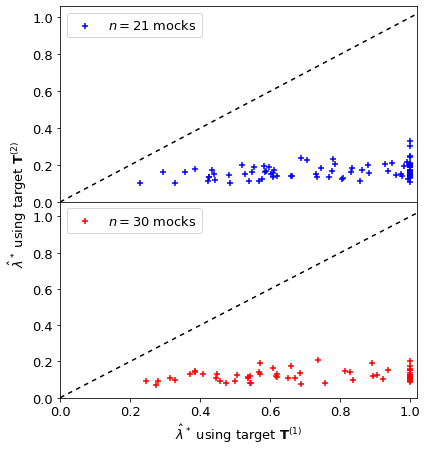

In [18]:
l_S_21 = np.loadtxt(os.path.join(mat_path, "n21", "lambdas_Sii_21.dat"))
l_P_21 = np.loadtxt(os.path.join(mat_path, "n21", "lambdas_P_21.dat"))
l_S_30 = np.loadtxt(os.path.join(mat_path, "n30", "lambdas_Sii_30.dat"))
l_P_30 = np.loadtxt(os.path.join(mat_path, "n30", "lambdas_P_30.dat"))

fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)
fig.set_size_inches(6.4, 7.2)

xs = ys = np.linspace(0, 1.1, 100)

axs[0].scatter(l_S_21, l_P_21, c="blue", marker="+", label="$n=21$ mocks")
axs[0].plot(xs, ys, ls="-", dashes=(3,3), c="black")
axs[0].legend(fontsize=13)
axs[0].set_xlim([0.0, 1.02])
axs[0].set_ylim([0.0, 1.06])
axs[0].tick_params(axis='both', which='major', labelsize=13)

axs[1].scatter(l_S_30, l_P_30, c="red", marker="+", label="$n=30$ mocks")
axs[1].plot(xs, ys, ls="-", dashes=(3,3), c="black")
axs[1].legend(fontsize=13)
axs[1].set_ylim([0.0, 1.08])
axs[1].set_xlabel(r"$\hat{\lambda}^*$ using target $\mathbf{T}^{(1)}$", fontsize=13)
axs[1].tick_params(axis='both', which='major', labelsize=13)

fig.supylabel(r"$\hat{\lambda}^*$ using target $\mathbf{T}^{(2)}$", fontsize=13, x=0.01)

#fig.savefig("../output/BOSS_DR12_NGC_z1/plots/lambdas.eps", format="eps", bbox_inches='tight', pad_inches = 0.1)
plt.show()

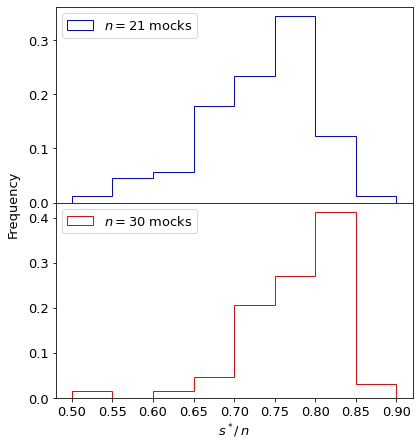

In [28]:
ss_min_21 = np.loadtxt(os.path.join(mat_path, "n21", "ss_min_21.dat"))
ss_min_30 = np.loadtxt(os.path.join(mat_path, "n30", "ss_min_30.dat"))

fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)
fig.set_size_inches(6.4, 7.2)

bins=np.linspace(0.5, 0.9, 9)

axs[0].hist(ss_min_21/21, bins=bins, color="blue", histtype="step", label="$n=21$ mocks", weights=np.ones_like(ss_min_21) / len(ss_min_21))
axs[0].legend(loc="upper left", fontsize=13)
axs[0].tick_params(axis='both', which='major', labelsize=13)

axs[1].hist(ss_min_30/30, bins=bins, color="red", histtype="step", label="$n=30$ mocks", weights=np.ones_like(ss_min_30) / len(ss_min_30))
axs[1].legend(loc="upper left", fontsize=13)
axs[1].tick_params(axis='both', which='major', labelsize=13)

axs[1].set_xlabel(r"$s^* /\, n$", fontsize=13)
fig.supylabel("Frequency", fontsize=13)

#fig.savefig("../output/BOSS_DR12_NGC_z1/plots/ss_min.eps", format="eps", bbox_inches='tight', pad_inches = 0.1)
plt.show()

In [38]:
a_inv_then_diag_21 = np.loadtxt(os.path.join(mat_path, "n21", "alphas_inv_then_diag_21.dat"))
b_inv_then_diag_21 = np.loadtxt(os.path.join(mat_path, "n21", "betas_inv_then_diag_21.dat"))
a_diag_then_inv_21 = np.loadtxt(os.path.join(mat_path, "n21", "alphas_diag_then_inv_21.dat"))
b_diag_then_inv_21 = np.loadtxt(os.path.join(mat_path, "n21", "betas_diag_then_inv_21.dat"))
a_P_21 = np.loadtxt(os.path.join(mat_path, "n21", "alphas_P_21.dat"))
b_P_21 = np.loadtxt(os.path.join(mat_path, "n21", "betas_P_21.dat"))

a_inv_then_diag_30 = np.loadtxt(os.path.join(mat_path, "n30", "alphas_inv_then_diag_30.dat"))
b_inv_then_diag_30 = np.loadtxt(os.path.join(mat_path, "n30", "betas_inv_then_diag_30.dat"))
a_diag_then_inv_30 = np.loadtxt(os.path.join(mat_path, "n30", "alphas_diag_then_inv_30.dat"))
b_diag_then_inv_30 = np.loadtxt(os.path.join(mat_path, "n30", "betas_diag_then_inv_30.dat"))
a_P_30 = np.loadtxt(os.path.join(mat_path, "n30", "alphas_P_30.dat"))
b_P_30 = np.loadtxt(os.path.join(mat_path, "n30", "betas_P_30.dat"))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


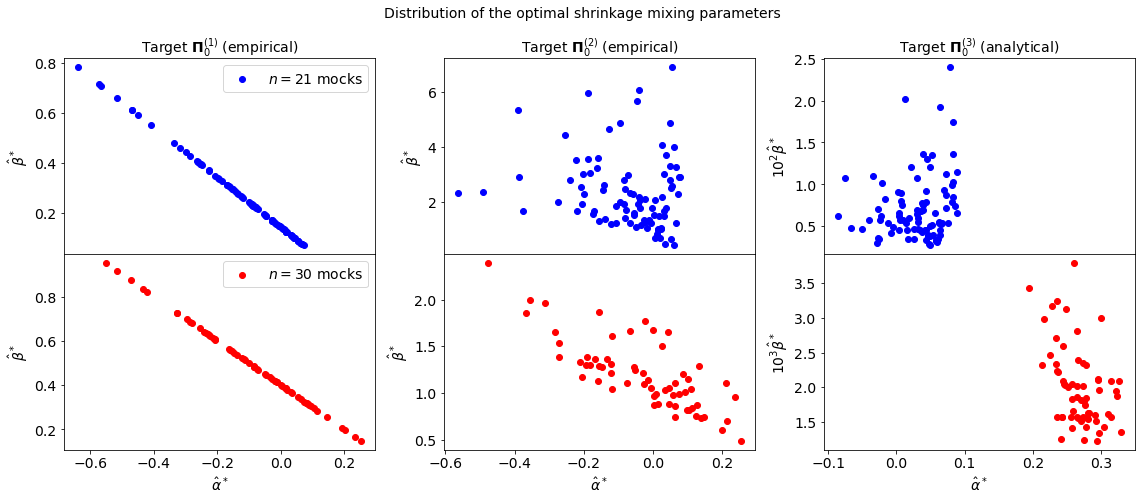

In [40]:
fig, axs = plt.subplots(2, 3, sharex="col")
fig.subplots_adjust(hspace=0, wspace=0.22)
fig.set_size_inches(19.2, 7.2)

axs[0,0].scatter(a_inv_then_diag_21, b_inv_then_diag_21, c="blue", label="$n=21$ mocks")
axs[0,0].set_title("Target $\mathbf{\Pi}_0^{(1)}$ (empirical)", fontsize=14)
axs[0,0].set_ylabel(r"$\hat{\beta}^*$", fontsize=14)
axs[0,0].legend(fontsize=14, loc="upper right")
axs[0,0].tick_params(axis='both', which='major', labelsize=14)

axs[1,0].scatter(a_inv_then_diag_30, b_inv_then_diag_30, c="red", label="$n=30$ mocks")
axs[1,0].set_xlabel(r"$\hat{\alpha}^*$", fontsize=14)
axs[1,0].set_ylabel(r"$\hat{\beta}^*$", fontsize=14)
axs[1,0].legend(fontsize=14, loc="upper right")
axs[1,0].tick_params(axis='both', which='major', labelsize=14)

axs[0,1].scatter(a_diag_then_inv_21, b_diag_then_inv_21, c="blue", label="$n=21$ mocks")
axs[0,1].set_title("Target $\mathbf{\Pi}_0^{(2)}$ (empirical)", fontsize=14)
axs[0,1].set_ylabel(r"$\hat{\beta}^*$", fontsize=14)
#axs[0,1].legend(fontsize=14, loc="upper right")
axs[0,1].tick_params(axis='both', which='major', labelsize=14)

axs[1,1].scatter(a_diag_then_inv_30, b_diag_then_inv_30, c="red", label="$n=30$ mocks")
axs[1,1].set_xlabel(r"$\hat{\alpha}^*$", fontsize=14)
axs[1,1].set_ylabel(r"$\hat{\beta}^*$", fontsize=14)
#axs[1,1].legend(fontsize=14, loc="upper right")
axs[1,1].tick_params(axis='both', which='major', labelsize=14)

axs[0,2].scatter(a_P_21, b_P_21*1e2, c="blue", label="$n=21$ mocks")
axs[0,2].set_title("Target $\mathbf{\Pi}_0^{(3)}$ (analytical)", fontsize=14)
axs[0,2].set_ylabel(r"$10^2\hat{\beta}^*$", fontsize=14)
#axs[0,2].legend(fontsize=14, loc="upper right")
axs[0,2].tick_params(axis='both', which='major', labelsize=14)

axs[1,2].scatter(a_P_30, b_P_30*1e3, c="red", label="$n=30$ mocks")
axs[1,2].set_xlabel(r"$\hat{\alpha}^*$", fontsize=14)
axs[1,2].set_ylabel(r"$10^3\hat{\beta}^*$", fontsize=14)
#axs[1,2].legend(fontsize=14, loc="upper right")
axs[1,2].tick_params(axis='both', which='major', labelsize=14)

fig.suptitle(r"Distribution of the optimal shrinkage mixing parameters", fontsize=14)
#fig.savefig("../output/BOSS_DR12_NGC_z1/plots/pre_shrinkage_params.eps", format="eps", bbox_inches='tight', pad_inches = 0.1)
plt.show()

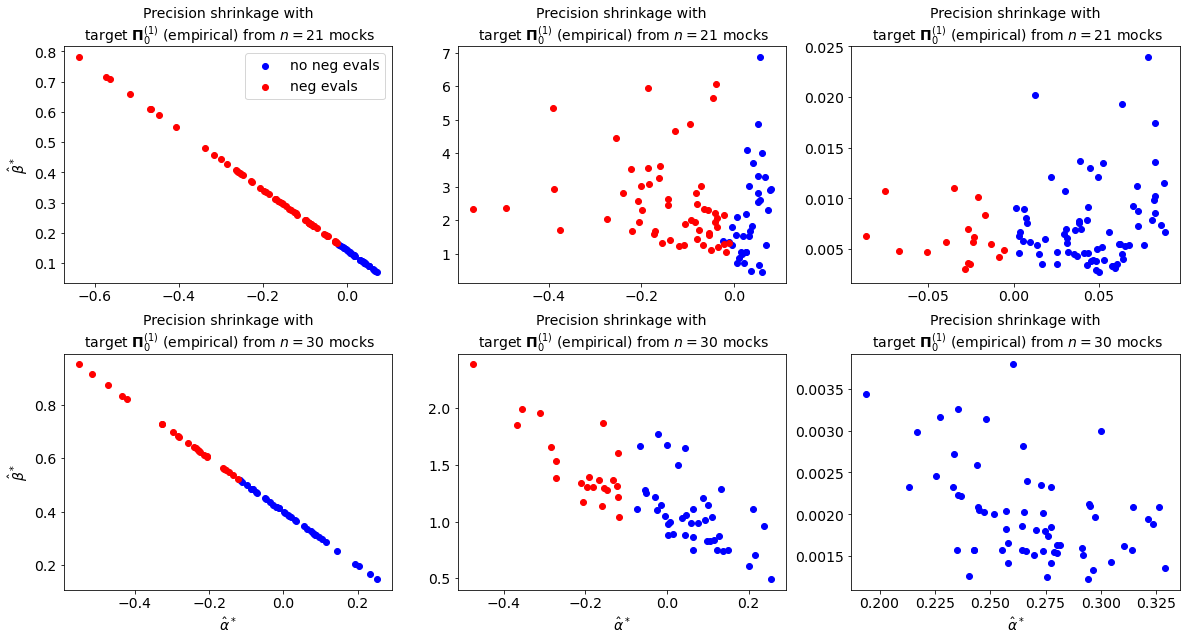

In [41]:
estimates = [
    ["shrinkage_inv_then_diag", "Precision shrinkage with\n target $\mathbf{\Pi}_0^{(1)}$ (empirical)"],
    ["shrinkage_diag_then_inv", "Precision shrinkage with\n target $\mathbf{\Pi}_0^{(1)}$ (empirical)"],
    ["shrinkage_P", "Precision shrinkage with\n target $\mathbf{\Pi}_0^{(1)}$ (empirical)"]
]
nsamples = [21,30]


fig, axs = plt.subplots(2, 3)#, sharex="col")
fig.subplots_adjust(hspace=0.3, wspace=0.2)
fig.set_size_inches(20, 10)

for k, estimate in enumerate(estimates):
    for l, n in enumerate(nsamples):
        data_path = os.path.join(mat_path, f"n{n}/pre_{estimate[0]}/")
        filenames = [f for f in os.listdir(data_path) if not f.startswith('.')]
        
        alphas_pos_eval = [] # Alphas belonging to precision matrix estimates which only have positive evals
        betas_pos_eval = [] # Betas "
        alphas_neg_eval = [] # Alphas belonging to precision matrix estimates which have at least one negative eval
        betas_neg_eval = [] # Betas "
        for filename in filenames:
            file_path = os.path.join(data_path, filename)
            
            with open(file_path) as f:
                first_line = f.readline().strip('\n')
            parts = first_line.split(",")
            alpha = float(parts[0].split("=")[1])
            beta = float(parts[1].split("=")[1])
            
            Cinv = np.loadtxt(file_path)
            evals = np.linalg.eigvalsh(Cinv)
            
            if np.min(evals) < 0:
                alphas_neg_eval.append(alpha)
                betas_neg_eval.append(beta)
            else:
                alphas_pos_eval.append(alpha)
                betas_pos_eval.append(beta)
            
        alphas_pos_eval = np.array(alphas_pos_eval)
        betas_pos_eval = np.array(betas_pos_eval)
        alphas_neg_eval = np.array(alphas_neg_eval)
        betas_neg_eval = np.array(betas_neg_eval)
        
        axs[l,k].scatter(alphas_pos_eval, betas_pos_eval, c="blue", label="no neg evals")
        axs[l,k].scatter(alphas_neg_eval, betas_neg_eval, c="red", label="neg evals")
        axs[l,k].set_title(estimate[1] + f" from $n={n}$ mocks", fontsize=14)
        axs[l,k].tick_params(axis='both', which='major', labelsize=14)
        #axs[l,k].set_title("Target $\mathbf{\Pi}_0^{(1)}$", fontsize=14)
        #axs[l,k].set_ylabel(r"$\hat{\beta}^*$", fontsize=14)
        #axs[l,k].legend(fontsize=14, loc="upper right")
        #axs[l,k].tick_params(axis='both', which='major', labelsize=14)
    
    axs[1, k].set_xlabel(r"$\hat{\alpha}^*$", fontsize=14)
axs[0,0].legend(fontsize=14)
axs[0,0].set_ylabel(r"$\hat{\beta}^*$", fontsize=14)
axs[1,0].set_ylabel(r"$\hat{\beta}^*$", fontsize=14)

#fig.savefig("../output/pre_shrinkage_params.pdf", format="pdf", bbox_inches='tight', pad_inches = 0.1)
plt.show()

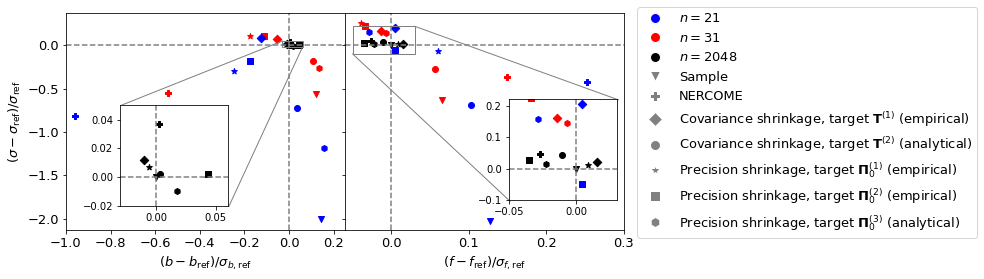

In [17]:
nsamples = [2048,30,21]
chains = [
    ["cov", "sample", "Sample"],
    ["cov", "NERCOME", "NERCOME"],
    ["cov", "shrinkage_Sii", "Covariance shrinkage, target $\mathbf{T}^{(1)}$ (empirical)"],
    ["cov", "shrinkage_P", "Covariance shrinkage, target $\mathbf{T}^{(2)}$ (analytical)"],
    ["pre", "shrinkage_inv_then_diag", "Precision shrinkage, target $\mathbf{\Pi}_0^{(1)}$ (empirical)"],
    ["pre", "shrinkage_diag_then_inv", "Precision shrinkage, target $\mathbf{\Pi}_0^{(2)}$ (empirical)"],
    ["pre", "shrinkage_P", "Precision shrinkage, target $\mathbf{\Pi}_0^{(3)}$ (analytical)"],
]

fig, axs = plt.subplots(1,2, sharey=True)
fig.subplots_adjust(wspace=0)
fig.set_size_inches(10, 4)

ref_chain_file = f"../output/BOSS_DR12_NGC_z1/samples/n2048/cov_sample/cov_sample_2048_results_v1.npy"
results_ref = np.load(ref_chain_file, allow_pickle=True)[()]
b_samples_ref = results_ref["samples"][:,0]
f_samples_ref = results_ref["samples"][:,1]
b_avg_ref = np.mean(b_samples_ref)
b_sig_ref = np.std(b_samples_ref)
f_avg_ref = np.mean(f_samples_ref)
f_sig_ref = np.std(f_samples_ref)

markers = ["v", "P", "D", "o", "*", "s", "h"]
colors=["black", "red", "blue"]

ax_in_b = fig.add_axes([0.2, 0.21, 0.15, 0.35])
ax_in_f = fig.add_axes([0.74, 0.23, 0.15, 0.35])

for k, n in enumerate(nsamples):
    for j, chain in enumerate(chains):
        mat_type = chain[0]
        est_type = chain[1]
        if n == 2048:
            file_path = f"../output/BOSS_DR12_NGC_z1/samples/n2048/{mat_type}_{est_type}/{mat_type}_{est_type}_2048_results_v1.npy"
            results = np.load(file_path, allow_pickle=True)[()]
            b_samples = results["samples"][:,0]
            f_samples = results["samples"][:,1]
        else:
            file_path = f"../output/BOSS_DR12_NGC_z1/samples/n{n}/{mat_type}_{est_type}_{n}.npy"
            results = np.load(file_path, allow_pickle=True)[()]
            b_samples = results.samples[:,0]
            f_samples = results.samples[:,1]
        
        x_vals_b = (b_avg_ref-np.mean(b_samples))/b_sig_ref
        y_vals_b = (b_sig_ref-np.std(b_samples))/b_sig_ref
        x_vals_f = (f_avg_ref-np.mean(f_samples))/f_sig_ref
        y_vals_f = (f_sig_ref-np.std(f_samples))/f_sig_ref
        
        axs[0].scatter(x_vals_b, y_vals_b, marker=markers[j], c=colors[k])
        axs[1].scatter(x_vals_f, y_vals_f, marker=markers[j], c=colors[k])
        
        ax_in_b.scatter(x_vals_b, y_vals_b, marker=markers[j], c=colors[k])
        ax_in_f.scatter(x_vals_f, y_vals_f, marker=markers[j], c=colors[k])


axs[0].axvline(0, ls="dashed", c="gray")
axs[0].axhline(0, ls="dashed", c="gray")
ax_in_b.axvline(0, ls="dashed", c="gray")
ax_in_b.axhline(0, ls="dashed", c="gray")

axs[1].axvline(0, ls="dashed", c="gray")
axs[1].axhline(0, ls="dashed", c="gray")
ax_in_f.axvline(0, ls="dashed", c="gray")
ax_in_f.axhline(0, ls="dashed", c="gray")

axs[0].set_ylabel(r"$(\sigma-\sigma_{\rm ref})/\sigma_{\rm ref}$", fontsize=13)
axs[0].set_xlabel(r"$(b-b_{\rm ref}) / \sigma_{b,\rm{ref}}$", fontsize=13)
axs[0].tick_params(axis='both', which='major', labelsize=13)
axs[0].set_xlim(-1.0, 0.25)

axs[1].set_xlabel(r"$(f-f_{\rm ref}) / \sigma_{f,\rm{ref}}$", fontsize=13)
axs[1].tick_params(axis='both', which='major', labelsize=13)
axs[1].set_xlim(-0.06, 0.3)

ax_in_b.set_xlim(-0.03,0.06)
ax_in_b.set_xticks([0,0.05])
ax_in_b.set_ylim(-0.02,0.05)

ax_in_f.set_xlim(-0.05,0.03)
ax_in_f.set_ylim(-0.1,0.22)

rec_b = patches.Rectangle(
    (ax_in_b.get_xlim()[0], ax_in_b.get_ylim()[0]),
    ax_in_b.get_xlim()[1]-ax_in_b.get_xlim()[0],
    ax_in_b.get_ylim()[1]-ax_in_b.get_ylim()[0],
    linewidth=1,
    edgecolor="gray",
    facecolor="none"
)
axs[0].add_patch(rec_b)

rec_f = patches.Rectangle(
    (ax_in_f.get_xlim()[0], ax_in_f.get_ylim()[0]),
    ax_in_f.get_xlim()[1]-ax_in_f.get_xlim()[0],
    ax_in_f.get_ylim()[1]-ax_in_f.get_ylim()[0],
    linewidth=1,
    edgecolor="gray",
    facecolor="none"
)
axs[1].add_patch(rec_f)

axs[0].plot([-0.75, ax_in_b.get_xlim()[0]], [-0.69, ax_in_b.get_ylim()[1]], c="gray", linewidth=1)
axs[0].plot([-0.27, ax_in_b.get_xlim()[1]], [-1.86, ax_in_b.get_ylim()[0]], c="gray", linewidth=1)
axs[1].plot([ax_in_f.get_xlim()[0], 0.153], [ax_in_f.get_ylim()[0], -1.8], c="gray", linewidth=1)
axs[1].plot([ax_in_f.get_xlim()[1], 0.293], [ax_in_f.get_ylim()[1], -0.63], c="gray", linewidth=1)

custom_lines = [
    Line2D([0], [0], marker='o', color='w', label='$n=21$', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='$n=31$', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='$n=2048$', markerfacecolor='black', markersize=10)
]
for j, chain in enumerate(chains):
    label = chain[2]
    custom_lines.append(
        Line2D([0], [0], marker=markers[j], color='w', label=label, markerfacecolor='grey', markersize=10)
    )
fig.legend(handles=custom_lines, ncols=1, loc="center right", bbox_to_anchor=(1.4,0.5), fontsize=13)

#fig.savefig("../output/BOSS_DR12_NGC_z1/plots/estimated_params.eps", format="eps", bbox_inches='tight', pad_inches = 0.1)
plt.show()